In [1]:
import pandas as pd
import numpy as np
import random
import re
import pickle
from typing import List, Tuple, Optional, Dict

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from wordcloud import WordCloud


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB


import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
    print("*** Be careful no warnings are printed ***")
    

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

*** Be careful no warnings are printed ***


[nltk_data] Downloading package wordnet to /home/rozhix/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/rozhix/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /home/rozhix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/rozhix/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
def read_data(path:str, columns_name: list):
    '''
    This function reads csv data and assigns column names to the data
    '''
    try:
        data = pd.read_csv(path, sep='\t', header=None, names=columns_name)
    except pd.errors.ParserError:
        data = pd.read_csv(path, sep='\t', header=None, error_bad_lines=False, names=columns_name)
    return data    


def change_labelling(df: pd.DataFrame, column_name: str, primary_label: list, target_label: str):
    '''
    This function allows for the modification of the label or labels of one or more classes, replacing them with a different label.
    '''
    df[column_name] = df[column_name].replace(primary_label, target_label)
    return df[column_name]


def heatmap_tweet_length(df: pd.DataFrame):
    # Create a heatmap of the correlation between tweet length and sentiment labels
    corr = df[['label', 'tweet_text']].apply(lambda x: x.str.len()).corr()
    fig = px.imshow(corr)
    fig = fig.show(renderer='colab')
    return 
    

def preprocess_tweet_text(tweet, stop_words=None):
    '''
    This function preprocesses tweets;
    1)Convert to lowercase
    2)Remove URLs
    3)Remove mentions
    4)Remove hashtags
    5)Remove numbers
    6)Remove retweets
    7)Remove punctuation
    8)Tokenize words
    9)Remove stop words
    '''

    stop_words = set(stopwords.words('english')) if stop_words == None else stop_words

    tweet = tweet.lower()
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@\w+', '', tweet)
    tweet = re.sub(r'#\w+', '', tweet)
    tweet = re.sub(r'\d+', '', tweet)
    tweet = re.sub(r'RT : ', '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    words = word_tokenize(tweet)
    words = [word for word in words if word not in stop_words]
    tweet = ' '.join(words)
    return tweet



def get_unigrams(df: pd.DataFrame, column_name: str):
    '''
    This function returns unigrams of a dataframe column and sort them 
    '''
    unigrams = pd.Series(' '.join(df[column_name]).split()).value_counts().sort_values()
    return unigrams 


def save_csv(data, path, file_name):
    data.to_csv(path+'/'+file_name+'.csv')
    
    
# Define the data augmentation functions
def synonym_replacement(words, n=1):
    '''
    This function randomly selects a word from the input sentence and replaces it with a synonym chosen from WordNet.
    This can help increase the diversity of words in the sentence.
    The default value for n is 1, which means that the function will randomly select one word from the input words list and replace it with a synonym chosen from WordNet.
    '''
    new_words = words.copy()
    for _ in range(n):
        random_word = random.choice(words)
        synonyms = set(wordnet.synsets(random_word))
        if synonyms:
            synonym = random.choice(list(synonyms)).lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
    return new_words


def random_deletion(words, p=0.5):
    '''
    This function randomly removes words from the input sentence with a probability of p.
    This can help simulate missing or noisy data.
    '''
    new_words = []
    for word in words:
        if random.uniform(0, 1) < p:
            continue
        new_words.append(word)
    return new_words


def random_swap(words, n=1):
    '''
    This function randomly selects two words in the input sentence and swaps their positions.
    This can help increase the variability of the sentence structure.
    '''
    new_words = words.copy()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        new_words[idx1], new_words[idx2] = new_words[idx2], new_words[idx1]
    return new_words


def random_insertion(words, n=1):
    '''
    This function randomly selects a word from the input sentence and inserts it at a random position in the sentence.
    This can help increase the variability of the sentence structure and add new words to the sentence.
    '''
    new_words = words.copy()
    for _ in range(n):
        random_word = random.choice(words)
        new_words.insert(random.randint(0,len(words)),random_word)
    return new_words    


def remove_high_probability_unigrams(unigrams_list: pd.Series, unigrams_number_to_remove: int, removing_words: list, stop_words: set, df: pd.DataFrame, column_name: str):
    removed_words = []
    not_removed_words = []    
    high_prob_unigrams = unigrams_list[-unigrams_number_to_remove:].index.tolist()
    for word in removing_words:
        try:
            high_prob_unigrams.remove(word)
            removed_words.append(word)
        except ValueError:
            print(f"{word} was not in the high probability unigrams list.")
            not_removed_words.append(word)
    if len(removed_words) == len(removing_words):
        print("All words were removed successfully.")
    else:
        if removed_words:
            print(f"The following words were removed: {removed_words}.")
        if not_removed_words:
            print(f"The following words were not removed: {not_removed_words}.")
    
        
    df[column_name] = df[column_name].apply(lambda tweet: ' '.join([word for word in tweet.split() if word not in high_prob_unigrams]))
    return df 


def create_feature_vectors_by_TF_IDF_vectorizer(df_train: pd.DataFrame, df_test: pd.DataFrame, column_name: str):
    vectorizer = TfidfVectorizer()
    train_data_vectors = vectorizer.fit_transform(df_train[column_name])
    test_data_vectors = vectorizer.transform(df_test[column_name])
    return train_data_vectors, test_data_vectors


def word_histogram(sentences, cutoff, title, color='#ff7f0e', stop_words=None):
    # Define the stop words
    stop_words = set(stopwords.words('english')) if stop_words == None else stop_words

    # Count frequency of each word
    word_count = WordCloud(background_color='white', stopwords=stop_words).process_text(' '.join(sentences))

    # make sure frequencies are sorted
    frequencies = pd.DataFrame(word_count, index =['Count'])
    frequencies = frequencies.T.sort_values(by=['Count'], ascending = False)

    # reform dataframe
    frequencies['Word'] = frequencies.index
    frequencies.reset_index(inplace=True)
    frequencies = frequencies[["Word", "Count"]]

    # Plot frequencies form the cutoff
    df = frequencies[frequencies['Count']>=cutoff]
    fig = px.histogram(y=df['Count'], x=df["Word"], color_discrete_sequence=[color], text_auto = True,)

    # Set Titles
    fig.update_layout(title=f'Word Count of {title}', xaxis_title='Words', yaxis_title='# Occurence')
    
    return fig.show(renderer='colab')


# Data Analysis

In this section, we read and plot our data. Also, we change labels, and see the most common words in our dataset. 

In [3]:
#Read The TSV Files And Concat Train Set With Dev Set
train_data = read_data(path='NLP_data/TrainingData.tsv', columns_name=['tweet_id', 'user_id', 'label', 'tweet_text'])
test_data = read_data(path='NLP_data/TestData.tsv', columns_name=['tweet_id', 'user_id', 'label', 'tweet_text'])
dev_data = read_data(path='NLP_data/DevData.tsv', columns_name=['tweet_id', 'user_id', 'label', 'tweet_text'])
train_data = pd.concat([train_data, dev_data])

Skipping line 3032: expected 4 fields, saw 6



In [4]:
#Ploting The Distribution Of Labels With Plotly
fig = px.histogram(train_data, x='label', text_auto = True,)
fig.update_layout(title='Distribution of Sentiment Labels', xaxis_title='Sentiment Label', yaxis_title='Number of Tweets')
#fig.show()
fig.show(renderer='colab')

In [26]:
#Changing The 'objective-OR-neutral' And 'objective' Label To 'Neutral' 
train_data['label'] = change_labelling(df=train_data, column_name='label', primary_label=['objective-OR-neutral', 'objective'], target_label='neutral')
test_data['label'] = change_labelling(df=test_data, column_name='label', primary_label=['objective-OR-neutral', 'objective'], target_label='neutral')

In [6]:
#Ploting The Distribution Of Labels
fig = px.histogram(train_data, x='label', color_discrete_sequence=['#ff7f0e'], text_auto = True,)
fig.update_layout(title='Distribution of Sentiment Labels after modifying "objective-OR-neutral" and "objective" to "neutral" ', xaxis_title='Sentiment Label', yaxis_title='Number of Tweets')
fig.show(renderer='colab')

In [7]:
#Correlation Between Length Of Tweets And Their Labels
heatmap_tweet_length(train_data)

In [9]:
# Analyzing Users' Tweets Condition
counts = train_data.groupby(['user_id', 'label']).size().unstack(fill_value=0)
counts['total'] = counts.sum(axis=1)
counts = counts.sort_values('total', ascending=False)
counts.to_csv('users.csv')
print(counts[:20])

label      negative  neutral  positive  total
user_id                                      
465572512         0        9         0      9
465114198         1        5         1      7
379829244         0        4         3      7
267317235         0        5         1      6
26572941          0        5         0      5
466358568         0        3         2      5
76443889          0        4         1      5
502454418         0        4         0      4
141049123         0        4         0      4
458398831         1        3         0      4
23182129          0        0         4      4
459204533         0        4         0      4
100986964         0        2         1      3
39453531          0        2         1      3
43775846          1        2         0      3
316414019         0        3         0      3
312872826         0        3         0      3
863418842         0        2         1      3
374173016         0        3         0      3
322775771         0        3      

## In this part, we plot the most common words

In [10]:
# Generate Word Frequency Bar Chart
word_histogram(train_data['tweet_text'], cutoff=190, title="Dataset")

In [11]:
# Loop Through Each Sentiment Class And Plot Word Frequency For Each class
for sentiment_label in train_data['label'].unique():
    # Filter the tweets for the current sentiment class
    tweets_for_sentiment = train_data[train_data['label'] == sentiment_label]['tweet_text']
    word_histogram(tweets_for_sentiment, cutoff=190, title=f"'{sentiment_label}' in Dataset")

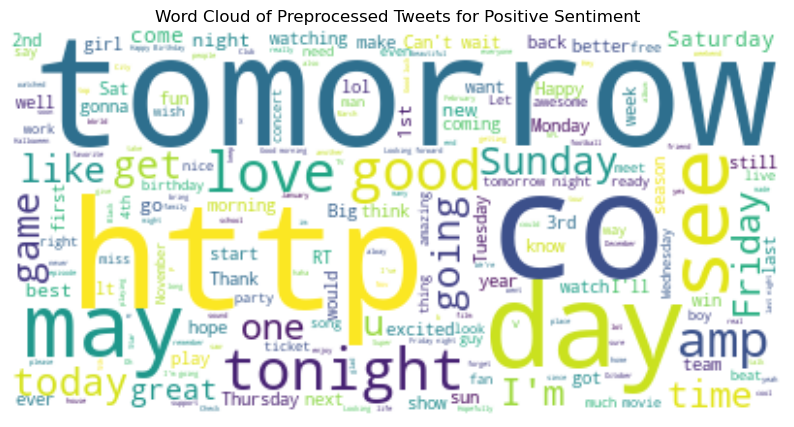

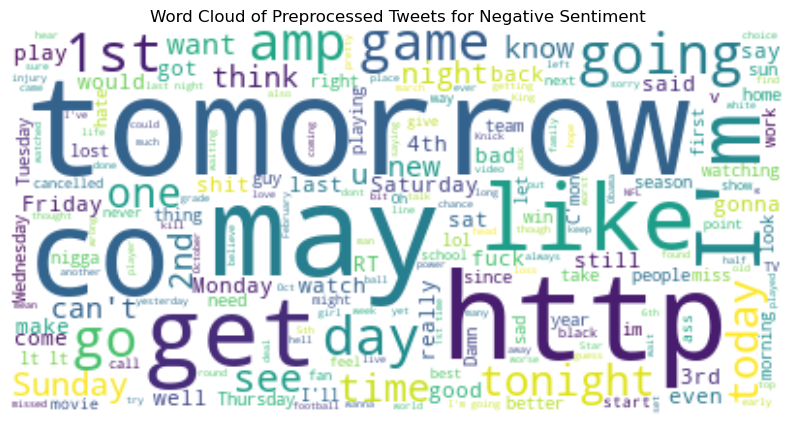

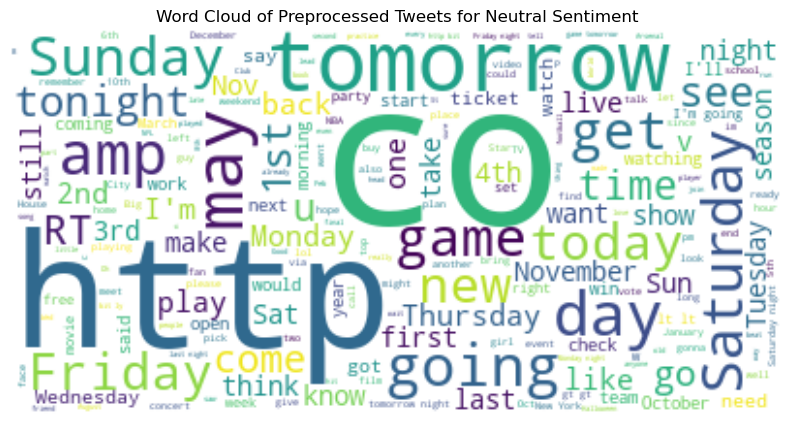

In [27]:
#Figure The WordCloud For Each Class
# Define the stop words
stop_words = set(stopwords.words('english'))

# Loop through each sentiment class
for sentiment_label in train_data['label'].unique():
    # Filter the tweets for the current sentiment class
    tweets_for_sentiment = train_data[train_data['label'] == sentiment_label]['tweet_text']
    
    # Generate the word cloud for the current sentiment class
    wordcloud = WordCloud(background_color='white', stopwords=stop_words).generate(' '.join(tweets_for_sentiment))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Preprocessed Tweets for {sentiment_label.capitalize()} Sentiment')
    plt.show()

# preprocessing

In [13]:
# Preprocess The Tweets; 1)Convert to lowercase, 2)Remove URLs, 3)Remove mentions, 4)Remove hashtags,
                       # 5)Remove numbers, 6)Remove retweets, 7)Remove punctuation, 8)Tokenize words, 9)Remove stop words

train_data['tweet_text'] = train_data['tweet_text'].apply(preprocess_tweet_text)
test_data['tweet_text'] = test_data['tweet_text'].apply(preprocess_tweet_text)

## In this part, we plot the most common words after preprocessing

In [14]:
## Generate Word Frequency Bar Chart After Preprocessing
word_histogram(train_data['tweet_text'], cutoff=190, title="Processed Dataset")

In [15]:
# Loop Through Each Sentiment Class And Plot Word Frequency For Each class
for sentiment_label in train_data['label'].unique():
    # Filter the tweets for the current sentiment class
    tweets_for_sentiment = train_data[train_data['label'] == sentiment_label]['tweet_text']
    word_histogram(tweets_for_sentiment, cutoff=190, title=f"'{sentiment_label}' in Dataset")

# Downsampling Method For Balancing Data

for downsampling:

    we first separate the three classes into different dataframes.
    
    Then, we downsample the majority classes 'neutral' and 'positive' to the same size as the minority class 'negative' using the resample function.
    
    The replace=False argument indicates that we are downsampling without replacement.
    
    The n_samples argument is set to the length of the minority class.
    
    Finally, we combine the downsampled majority classes with the minority class, shuffle the dataset, and reset the index.
    
    The resulting balanced_data dataframe will have the same number of samples for each class.

In [16]:
#DownSAMPLING
# Separate classes
positive_data = train_data[train_data['label'] == 'positive']
negative_data = train_data[train_data['label'] == 'negative']
neutral_data = train_data[train_data['label'] == 'neutral']

# Downsample majority classes
neutral_data_downsampled = resample(neutral_data, replace=False, n_samples=len(negative_data), random_state=42)
positive_data_downsampled = resample(positive_data, replace=False, n_samples=len(negative_data), random_state=42)

# Combine minority and downsampled majority classes
balanced_data = pd.concat([neutral_data_downsampled, positive_data_downsampled, negative_data])

# Shuffle the dataset
balanced_data_with_downsampling = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
print('Length of positive class after Downsampling:', len(balanced_data_with_downsampling[balanced_data_with_downsampling['label'] == 'positive']))
print('Length of neutral class after Downsampling:', len(balanced_data_with_downsampling[balanced_data_with_downsampling['label'] == 'neutral']))
print('Length of negative class after Downsampling:', len(balanced_data_with_downsampling[balanced_data_with_downsampling['label'] == 'negative']))


Length of positive class after Downsampling: 1439
Length of neutral class after Downsampling: 1439
Length of negative class after Downsampling: 1439


In [17]:
#Ploting The Distribution Of Labels After Balancing Data
fig = px.histogram(balanced_data_with_downsampling, x='label', text_auto = True, color_discrete_sequence=['purple'])
fig.update_layout(title='Distribution of Sentiment Labels after Downsampling', xaxis_title='Sentiment Label', yaxis_title='Number of Tweets')
#fig.show()
fig.show(renderer='colab')

# Upsampling Method For Balancing Data

For Upsampling:

    we first separate the three classes into different dataframes.

    Then, we upsample the minority class 'negative' to the same size as the majority classes 'neutral' and 'positive' using the resample function.

    The replace=True argument indicates that we are upsampling with replacement. The n_samples argument is set to the length of the majority class.

    Finally, we combine the upsampled minority class with the majority classes, shuffle the dataset, and reset the index.

    The resulting balanced_data dataframe will have the same number of samples for each class.

In [18]:
#UPSAMPLING
# Separate classes
positive_data = train_data[train_data['label'] == 'positive']
negative_data = train_data[train_data['label'] == 'negative']
neutral_data = train_data[train_data['label'] == 'neutral']

# Upsample minority class
negative_data_upsampled = resample(negative_data, replace=True, n_samples=len(neutral_data), random_state=42)
positive_data_upsampled = resample(positive_data, replace=True, n_samples=len(neutral_data), random_state=42)

# Combine minority and upsampled majority classes
balanced_data_with_upsampling = pd.concat([negative_data_upsampled, positive_data_upsampled, neutral_data])

# Shuffle the dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)
print('Length of positive class after Downsampling:', len(balanced_data_with_upsampling[balanced_data_with_upsampling['label'] == 'positive']))
print('Length of neutral class after Downsampling:', len(balanced_data_with_upsampling[balanced_data_with_upsampling['label'] == 'neutral']))
print('Length of negative class after Downsampling:', len(balanced_data_with_upsampling[balanced_data_with_upsampling['label'] == 'negative']))

Length of positive class after Downsampling: 4487
Length of neutral class after Downsampling: 4487
Length of negative class after Downsampling: 4487


In [19]:
#ploting the distribution of labels
fig = px.histogram(balanced_data_with_upsampling, x='label', text_auto = True, color_discrete_sequence=['green'])
fig.update_layout(title='Distribution of Sentiment Labels after Upsampling', xaxis_title='Sentiment Label', yaxis_title='Number of Tweets')
#fig.show()
fig.show(renderer='colab')

# Augmentaion For Balancing Data

In [20]:
# Separate the data into different classes
positive_class = train_data[train_data['label'] == 'positive']
neutral_class = train_data[train_data['label'] == 'neutral']
negative_class = train_data[train_data['label'] == 'negative']

# Calculate the length of the largest class
max_class_len = max(len(positive_class), len(neutral_class), len(negative_class))

# Augment the data for the negative class until it has the same length as the positive class
augmented_data = {'positive': [], 'neutral': [], 'negative': []}

while len(negative_class) < max_class_len:
    for index, row in negative_class.iterrows():
        words = word_tokenize(row['tweet_text'])
        augmented_data['negative'].append(' '.join(synonym_replacement(words)))
        augmented_data['negative'].append(' '.join(random_deletion(words)))
        augmented_data['negative'].append(' '.join(random_swap(words)))
        augmented_data['negative'].append(' '.join(random_insertion(words)))

    negative_class = pd.DataFrame({'label': ['negative'] * len(augmented_data['negative']),
                                'tweet_text': augmented_data['negative']})
    negative_class = resample(negative_class, replace=True, n_samples=max_class_len, random_state=42)
    
while len(positive_class) < max_class_len:
    for index, row in positive_class.iterrows():
        words = word_tokenize(row['tweet_text'])
        augmented_data['positive'].append(' '.join(synonym_replacement(words)))
        augmented_data['negative'].append(' '.join(random_deletion(words)))
        augmented_data['negative'].append(' '.join(random_swap(words)))
        augmented_data['negative'].append(' '.join(random_insertion(words)))

    positive_class = pd.DataFrame({'label': ['positive'] * len(augmented_data['positive']),
                                'tweet_text': augmented_data['positive']})
    positive_class = resample(positive_class, replace=True, n_samples=max_class_len, random_state=42)    

# Concatenate the dataframes for each class and shuffle the data
augmented_train_data = pd.concat([positive_class, neutral_class, negative_class], axis=0, ignore_index=True)
augmented_train_data = augmented_train_data.sample(frac=1).reset_index(drop=True)

# Print the length of each class after data augmentation
print('Length of positive class after data augmentation:', len(augmented_train_data[augmented_train_data['label'] == 'positive']))
print('Length of neutral class after data augmentation:', len(augmented_train_data[augmented_train_data['label'] == 'neutral']))
print('Length of negative class after data augmentation:', len(augmented_train_data[augmented_train_data['label'] == 'negative']))

Length of positive class after data augmentation: 4487
Length of neutral class after data augmentation: 4487
Length of negative class after data augmentation: 4487


In [21]:
#ploting the distribution of labels
fig = px.histogram(augmented_train_data, x='label', text_auto = True, color_discrete_sequence=['springgreen'])
fig.update_layout(title='Distribution of Sentiment Labels', xaxis_title='Sentiment Label', yaxis_title='Number of Tweets')
#fig.show()
fig.show(renderer='colab')

# Upsampling with augmentaion and Downsampling with resample function

In [23]:
# Separate the data into different classes
positive_class = train_data[train_data['label'] == 'positive']
neutral_class = train_data[train_data['label'] == 'neutral']
negative_class = train_data[train_data['label'] == 'negative']

# Calculate the length of the positive class
positive_class_len = len(positive_class)

# Augment the data for the negative class until it has the same length as the positive class
augmented_data = {'positive': [], 'neutral': [], 'negative': []}

while len(negative_class) < positive_class_len:
    for index, row in negative_class.iterrows():
        words = word_tokenize(row['tweet_text'])
        augmented_data['negative'].append(' '.join(synonym_replacement(words)))
        augmented_data['negative'].append(' '.join(random_deletion(words)))
        augmented_data['negative'].append(' '.join(random_swap(words)))
        augmented_data['negative'].append(' '.join(random_insertion(words)))

    negative_class = pd.DataFrame({'label': ['negative'] * len(augmented_data['negative']),
                                'tweet_text': augmented_data['negative']})
    negative_class = resample(negative_class, replace=True, n_samples=positive_class_len, random_state=42)

# Downsample netural class    
neutral_data_downsampled = resample(neutral_data, replace=False, n_samples=len(positive_data), random_state=42)
# Concatenate the dataframes for each class    
balanced_data = pd.concat([neutral_data_downsampled, positive_class, negative_class])
# Shuffle the dataset
balanced_data_with_augmentation_and_downsampling = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)    

print('Length of positive class after data augmentation:', len(balanced_data_with_augmentation_and_downsampling[balanced_data_with_augmentation_and_downsampling['label'] == 'positive']))
print('Length of neutral class after data augmentation:', len(balanced_data_with_augmentation_and_downsampling[balanced_data_with_augmentation_and_downsampling['label'] == 'neutral']))
print('Length of negative class after data augmentation:', len(balanced_data_with_augmentation_and_downsampling[balanced_data_with_augmentation_and_downsampling['label'] == 'negative']))

Length of positive class after data augmentation: 3457
Length of neutral class after data augmentation: 3457
Length of negative class after data augmentation: 3457


In [24]:
#ploting the distribution of labels
fig = px.histogram(balanced_data_with_augmentation_and_downsampling, x='label', text_auto = True, color_discrete_sequence=['deeppink'])
fig.update_layout(title='Distribution of Sentiment Labels after Augmentation and Downsampling', xaxis_title='Sentiment Label', yaxis_title='Number of Tweets')
#fig.show()
fig.show(renderer='colab')

# Unigrams

In [141]:
#Find Unigrams
unigrams = get_unigrams(df=balanced_data_with_augmentation_and_downsampling, column_name='tweet_text')
save_csv(data=unigrams, path='NLP_data', file_name='unigrams')
stop_words = set(stopwords.words('english'))


In [154]:
unigrams[-50:]

gon          228
season       228
well         230
would        238
morning      242
first        242
make         248
watch        248
us           257
know         258
pm           267
want         268
think        271
back         287
still        292
thursday     298
come         302
love         306
rd           315
na           321
got          322
cant         334
rt           339
last         353
dont         365
monday       391
new          394
nd           409
one          430
good         442
today        487
go           497
saturday     510
amp          526
friday       527
sunday       530
get          533
game         535
time         536
like         547
tonight      577
see          611
st           658
going        738
im           792
night        831
day          838
may         1039
th          1152
tomorrow    1716
dtype: int64

In [155]:
omit_words = ['go', 'get', 'time', 'like', 'game', 'see', 'may', 'going', 'day', 'night',
              'good', 'new', 'dont', 'last', 'cant', 'got', 'love', 'come', 'still', 'back', 'think', 'want', 'know', 'well'
              
              
]

In [156]:
train_data = remove_high_probability_unigrams(unigrams_list=unigrams, unigrams_number_to_remove=50, removing_words=omit_words, stop_words=stop_words, df=balanced_data_with_augmentation_and_downsampling, column_name='tweet_text')

All words were removed successfully.


# feature extraction

In [157]:
train_data_vectors, test_data_vectors = create_feature_vectors_by_TF_IDF_vectorizer(df_train=train_data, df_test=test_data, column_name='tweet_text')

# Test set Analysis

In [98]:
test_data = read_data(path='NLP_data/TestData.tsv', columns_name=['tweet_id', 'user_id', 'label', 'tweet_text'])
#ploting the distribution of labels
fig = px.histogram(test_data, x='label', text_auto = True,)
fig.update_layout(title='Distribution of test set Labels', xaxis_title='Sentiment Label', yaxis_title='Number of Tweets')
#fig.show()
fig.show(renderer='colab')

Skipping line 3032: expected 4 fields, saw 6



In [99]:
#if you want to preprocess the test and then plot the most common words polt, run this line, else continue and run following cells for plotting
test_data['tweet_text'] = test_data['tweet_text'].apply(preprocess_tweet_text)

In [113]:
# Generate Word Frequency Bar Chart
word_histogram(test_data['tweet_text'], cutoff=90, title="testset after preprocessing", color='red')

In [112]:
# Loop through each sentiment class
for sentiment_label in test_data['label'].unique():
    # Filter the tweets for the current sentiment class
    tweets_for_sentiment = test_data[test_data['label'] == sentiment_label]['tweet_text']
    word_histogram(tweets_for_sentiment, cutoff=90, title=f"'{sentiment_label}' in Testset", color='red')

In [81]:
#preprocess test set 
test_data['tweet_text'] = test_data['tweet_text'].apply(preprocess_tweet_text)

In [82]:
# Generate Word Frequency Bar Chart
word_histogram(test_data['tweet_text'], cutoff=190, title="Dataset")

In [28]:
# Loop through each sentiment class
for sentiment_label in test_data['label'].unique():
    # Filter the tweets for the current sentiment class
    tweets_for_sentiment = test_data[test_data['label'] == sentiment_label]['tweet_text']
    word_histogram(tweets_for_sentiment, cutoff=90, title=f"'{sentiment_label}' in Dataset")

# Hyperparameter tuning and ensemble

##  Hyperparameter tuning And Ensemble for Downsampling Method

Accuracy: 0.6187440229518648


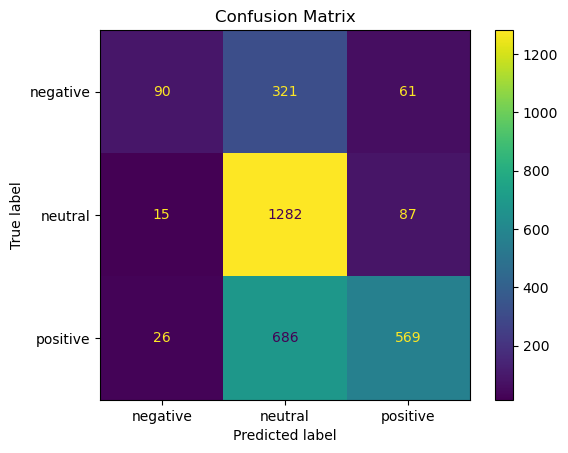

,precision,recall,f1-score,support
negative,0.687023,0.190678,0.298507,472.000000
neutral,0.560070,0.926301,0.698067,1384.000000
positive,0.793584,0.444184,0.569570,1281.000000
accuracy,0.618744,0.618744,0.618744,0.618744
macro avg,0.680226,0.520388,0.522048,3137.000000
weighted avg,0.674528,0.618744,0.585476,3137.000000


In [69]:
# Define the models to tune and ensemble for downsampling
svc = SVC()
rfc = RandomForestClassifier()
lr = LogisticRegression()
nb = MultinomialNB()

# Set the hyperparameter ranges for each model
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid']}
rfc_params = {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, 30, None], 'random_state': [66, None]}
lr_params = [
    {'penalty': ['l2', None], 'C': [0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [100, 200, 300], 'random_state': [66, None]},
    {'penalty': ['l1', None], 'C': [0.1, 1, 10], 'solver': ['liblinear'], 'max_iter': [100, 200, 300], 'random_state': [66, None]}
]
nb_params = {'alpha': [0.1, 1, 10]}

#Perform grid search on each model
svc_gs = GridSearchCV(svc, svc_params, cv=5, n_jobs=-1)
svc_gs.fit(train_data_vectors, train_data['label'])
svc_best = svc_gs.best_estimator_

rfc_gs = GridSearchCV(rfc, rfc_params, cv=5, n_jobs=-1)
rfc_gs.fit(train_data_vectors, train_data['label'])
rfc_best = rfc_gs.best_estimator_

lr_gs = GridSearchCV(lr, lr_params, cv=5, n_jobs=-1)
lr_gs.fit(train_data_vectors, train_data['label'])
lr_best = lr_gs.best_estimator_

nb_gs = GridSearchCV(nb, nb_params, cv=5, n_jobs=-1)
nb_gs.fit(train_data_vectors, train_data['label'])
nb_best = nb_gs.best_estimator_

# Create the ensemble model with the best estimators from each model
ensemble = VotingClassifier(estimators=[
    ('svc', svc_best),
    ('rfc', rfc_best),
    ('lr', lr_best),
    ('nb', nb_best)
], voting='hard', n_jobs=-1)

# Train the ensemble model
ensemble.fit(train_data_vectors, train_data['label'])


# Save the trained ensemble model
with open('ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble, f)



# Make predictions on the test set and calculate accuracy
test_pred = ensemble.predict(test_data_vectors)
accuracy = accuracy_score(test_data['label'], test_pred)
print('Accuracy:', accuracy)


# Plot the confusion matrix
plot_confusion_matrix(ensemble, test_data_vectors, test_data['label'], display_labels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.show()


report = classification_report(test_data['label'], test_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('models_result/ensembling_with_downsampling.csv')
df

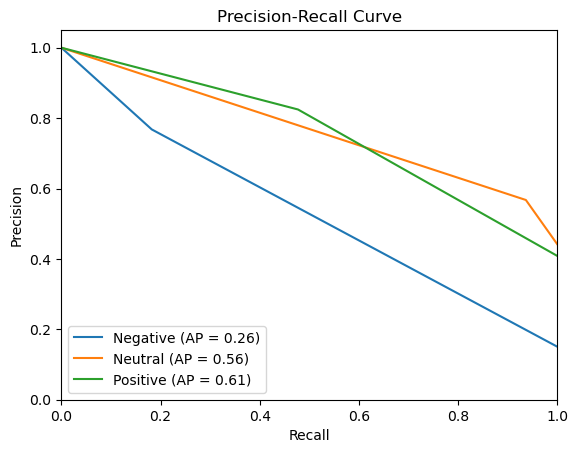

In [25]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Make predictions on the test set using the ensemble model with hard voting
test_pred = ensemble.predict(test_data_vectors)

# Get binary labels for each class
test_labels_negative = (test_data['label'] == 'negative')
test_labels_neutral = (test_data['label'] == 'neutral')
test_labels_positive = (test_data['label'] == 'positive')

# Get binary predictions for each class
test_pred_negative = (test_pred == 'negative')
test_pred_neutral = (test_pred == 'neutral')
test_pred_positive = (test_pred == 'positive')

# Calculate precision, recall, and average precision for each class
precision_negative, recall_negative, _ = precision_recall_curve(test_labels_negative, test_pred_negative)
precision_neutral, recall_neutral, _ = precision_recall_curve(test_labels_neutral, test_pred_neutral)
precision_positive, recall_positive, _ = precision_recall_curve(test_labels_positive, test_pred_positive)

average_precision_negative = average_precision_score(test_labels_negative, test_pred_negative)
average_precision_neutral = average_precision_score(test_labels_neutral, test_pred_neutral)
average_precision_positive = average_precision_score(test_labels_positive, test_pred_positive)

# Plot the precision-recall curves
plt.plot(recall_negative, precision_negative, label='Negative (AP = %0.2f)' % average_precision_negative)
plt.plot(recall_neutral, precision_neutral, label='Neutral (AP = %0.2f)' % average_precision_neutral)
plt.plot(recall_positive, precision_positive, label='Positive (AP = %0.2f)' % average_precision_positive)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()



##  Hyperparameter tuning And Ensemble for Upsampling Method

Accuracy: 0.6353203697800446


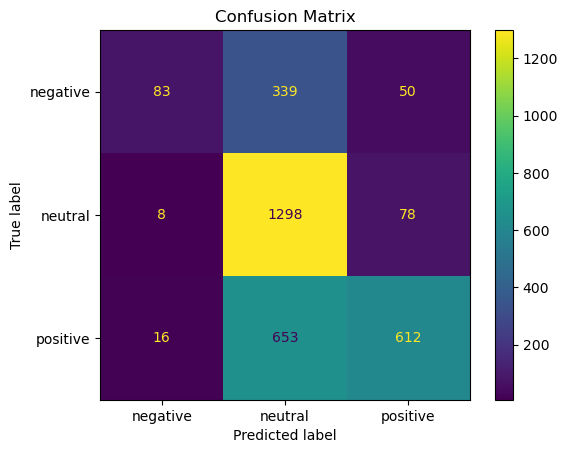

,precision,recall,f1-score,support
negative,0.775701,0.175847,0.286701,472.00000
neutral,0.566812,0.937861,0.706587,1384.00000
positive,0.827027,0.477752,0.605641,1281.00000
accuracy,0.635320,0.635320,0.635320,0.63532
macro avg,0.723180,0.530487,0.532976,3137.00000
weighted avg,0.704501,0.635320,0.602188,3137.00000


In [30]:
# Define the models to tune and ensemble upsampling
svc = SVC()
rfc = RandomForestClassifier()
lr = LogisticRegression()
nb = MultinomialNB()


# Set the hyperparameter ranges for each model
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid'], 'random_state': [66]}
rfc_params = {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, 30, None], 'random_state': [66]}
lr_params = [
    {'penalty': ['l2', None], 'C': [0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [100, 200, 300], 'random_state': [66]},
    {'penalty': ['l1', None], 'C': [0.1, 1, 10], 'solver': ['liblinear'], 'max_iter': [100, 200, 300], 'random_state': [66]}
]
nb_params = {'alpha': [0.1, 1, 10]}

#Perform grid search on each model
svc_gs = GridSearchCV(svc, svc_params, cv=5, n_jobs=-1)
svc_gs.fit(train_data_vectors, train_data['label'])
svc_best = svc_gs.best_estimator_

rfc_gs = GridSearchCV(rfc, rfc_params, cv=5, n_jobs=-1)
rfc_gs.fit(train_data_vectors, train_data['label'])
rfc_best = rfc_gs.best_estimator_

lr_gs = GridSearchCV(lr, lr_params, cv=5, n_jobs=-1)
lr_gs.fit(train_data_vectors, train_data['label'])
lr_best = lr_gs.best_estimator_

nb_gs = GridSearchCV(nb, nb_params, cv=5, n_jobs=-1)
nb_gs.fit(train_data_vectors, train_data['label'])
nb_best = nb_gs.best_estimator_

# Create the ensemble model with the best estimators from each model
ensemble = VotingClassifier(estimators=[
    ('svc', svc_best),
    ('rfc', rfc_best),
    ('lr', lr_best),
    ('nb', nb_best)
], voting='hard')

# Train the ensemble model
ensemble.fit(train_data_vectors, train_data['label'])


# Save the trained ensemble model
with open('ensemble_model_upsampling.pkl', 'wb') as f:
    pickle.dump(ensemble, f)



# Make predictions on the test set and calculate accuracy
test_pred = ensemble.predict(test_data_vectors)
accuracy = accuracy_score(test_data['label'], test_pred)
print('Accuracy:', accuracy)


# Plot the confusion matrix
plot_confusion_matrix(ensemble, test_data_vectors, test_data['label'], display_labels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.show()


report = classification_report(test_data['label'], test_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('models_result/ensembling_with_upsampling.csv')
df

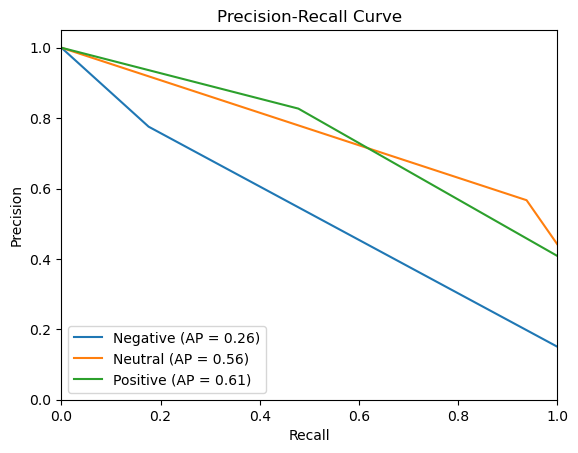

In [31]:
# Make predictions on the test set using the ensemble model with hard voting
test_pred = ensemble.predict(test_data_vectors)

# Get binary labels for each class
test_labels_negative = (test_data['label'] == 'negative')
test_labels_neutral = (test_data['label'] == 'neutral')
test_labels_positive = (test_data['label'] == 'positive')

# Get binary predictions for each class
test_pred_negative = (test_pred == 'negative')
test_pred_neutral = (test_pred == 'neutral')
test_pred_positive = (test_pred == 'positive')

# Calculate precision, recall, and average precision for each class
precision_negative, recall_negative, _ = precision_recall_curve(test_labels_negative, test_pred_negative)
precision_neutral, recall_neutral, _ = precision_recall_curve(test_labels_neutral, test_pred_neutral)
precision_positive, recall_positive, _ = precision_recall_curve(test_labels_positive, test_pred_positive)

average_precision_negative = average_precision_score(test_labels_negative, test_pred_negative)
average_precision_neutral = average_precision_score(test_labels_neutral, test_pred_neutral)
average_precision_positive = average_precision_score(test_labels_positive, test_pred_positive)

# Plot the precision-recall curves
plt.plot(recall_negative, precision_negative, label='Negative (AP = %0.2f)' % average_precision_negative)
plt.plot(recall_neutral, precision_neutral, label='Neutral (AP = %0.2f)' % average_precision_neutral)
plt.plot(recall_positive, precision_positive, label='Positive (AP = %0.2f)' % average_precision_positive)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Hyperparameter tuning And Ensemble for Augmentation Method

Accuracy: 0.6324513866751673


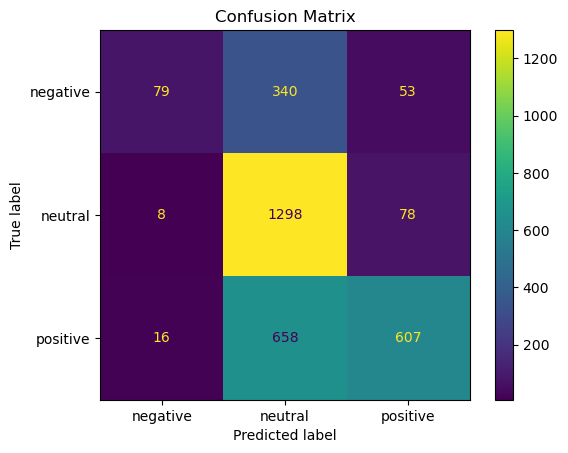

,precision,recall,f1-score,support
negative,0.766990,0.167373,0.274783,472.000000
neutral,0.565331,0.937861,0.705435,1384.000000
positive,0.822493,0.473849,0.601288,1281.000000
accuracy,0.632451,0.632451,0.632451,0.632451
macro avg,0.718272,0.526361,0.527168,3137.000000
weighted avg,0.700686,0.632451,0.598109,3137.000000


In [85]:
# Define the models to tune and ensemble augment
svc = SVC()
rfc = RandomForestClassifier()
lr = LogisticRegression()
nb = MultinomialNB()


# Set the hyperparameter ranges for each model
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid'], 'random_state': [66]}
rfc_params = {'n_estimators': [50, 100, 150], 'max_depth': [10, 20, 30, None]}
lr_params = [
    {'penalty': ['l2', None], 'C': [0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [100, 200, 300], 'random_state': [66]},
    {'penalty': ['l1', None], 'C': [0.1, 1, 10], 'solver': ['liblinear'], 'max_iter': [100, 200, 300], 'random_state': [66]}
]
nb_params = {'alpha': [0.1, 1, 10]}

#Perform grid search on each model
svc_gs = GridSearchCV(svc, svc_params, cv=5, n_jobs=-1)
svc_gs.fit(train_data_vectors, train_data['label'])
svc_best = svc_gs.best_estimator_

rfc_gs = GridSearchCV(rfc, rfc_params, cv=5, n_jobs=-1)
rfc_gs.fit(train_data_vectors, train_data['label'])
rfc_best = rfc_gs.best_estimator_

lr_gs = GridSearchCV(lr, lr_params, cv=5, n_jobs=-1)
lr_gs.fit(train_data_vectors, train_data['label'])
lr_best = lr_gs.best_estimator_

nb_gs = GridSearchCV(nb, nb_params, cv=5, n_jobs=-1)
nb_gs.fit(train_data_vectors, train_data['label'])
nb_best = nb_gs.best_estimator_

# Create the ensemble model with the best estimators from each model
ensemble = VotingClassifier(estimators=[
    ('svc', svc_best),
    ('rfc', rfc_best),
    ('lr', lr_best),
    ('nb', nb_best)
], voting='hard')

# Train the ensemble model
ensemble.fit(train_data_vectors, train_data['label'])


# Save the trained ensemble model
with open('ensemble_model_augmentation.pkl', 'wb') as f:
    pickle.dump(ensemble, f)



# Make predictions on the test set and calculate accuracy
test_pred = ensemble.predict(test_data_vectors)
accuracy = accuracy_score(test_data['label'], test_pred)
print('Accuracy:', accuracy)


# Plot the confusion matrix
plot_confusion_matrix(ensemble, test_data_vectors, test_data['label'], display_labels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.show()


report = classification_report(test_data['label'], test_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('models_result/ensembling_with_augmentation.csv')
df

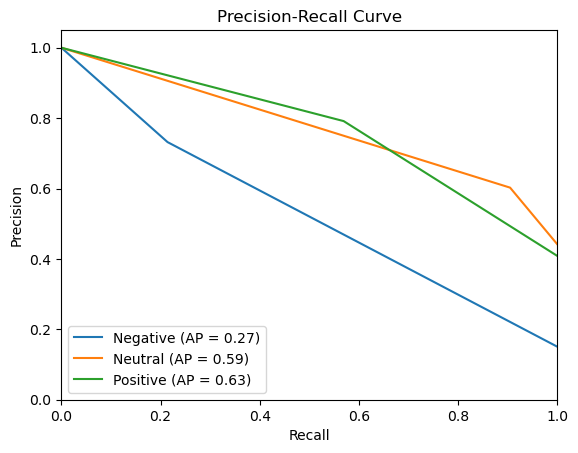

In [94]:
# Make predictions on the test set using the ensemble model with hard voting
test_pred = ensemble.predict(test_data_vectors)

# Get binary labels for each class
test_labels_negative = (test_data['label'] == 'negative')
test_labels_neutral = (test_data['label'] == 'neutral')
test_labels_positive = (test_data['label'] == 'positive')

# Get binary predictions for each class
test_pred_negative = (test_pred == 'negative')
test_pred_neutral = (test_pred == 'neutral')
test_pred_positive = (test_pred == 'positive')

# Calculate precision, recall, and average precision for each class
precision_negative, recall_negative, _ = precision_recall_curve(test_labels_negative, test_pred_negative)
precision_neutral, recall_neutral, _ = precision_recall_curve(test_labels_neutral, test_pred_neutral)
precision_positive, recall_positive, _ = precision_recall_curve(test_labels_positive, test_pred_positive)

average_precision_negative = average_precision_score(test_labels_negative, test_pred_negative)
average_precision_neutral = average_precision_score(test_labels_neutral, test_pred_neutral)
average_precision_positive = average_precision_score(test_labels_positive, test_pred_positive)

# Plot the precision-recall curves
plt.plot(recall_negative, precision_negative, label='Negative (AP = %0.2f)' % average_precision_negative)
plt.plot(recall_neutral, precision_neutral, label='Neutral (AP = %0.2f)' % average_precision_neutral)
plt.plot(recall_positive, precision_positive, label='Positive (AP = %0.2f)' % average_precision_positive)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Hyperparameter tuning And Ensemble for Augmentaion and Downsampling

Accuracy: 0.6636914249282754


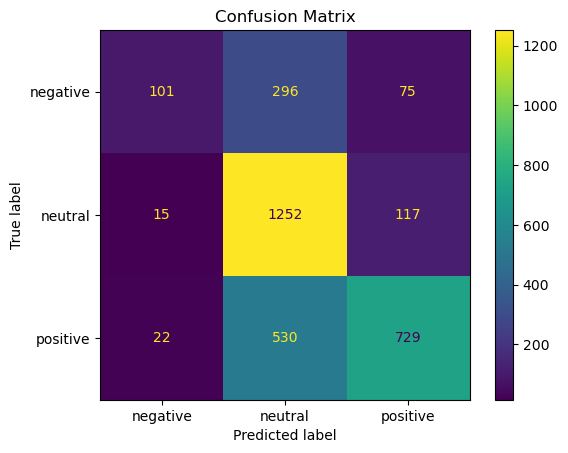

,precision,recall,f1-score,support
negative,0.731884,0.213983,0.331148,472.000000
neutral,0.602502,0.904624,0.723281,1384.000000
positive,0.791531,0.569087,0.662125,1281.000000
accuracy,0.663691,0.663691,0.663691,0.663691
macro avg,0.708639,0.562565,0.572185,3137.000000
weighted avg,0.699160,0.663691,0.639307,3137.000000


In [93]:
# Define the models to tune and ensemble augment
svc = SVC()
rfc = RandomForestClassifier()
lr = LogisticRegression()
nb = MultinomialNB()


# Set the hyperparameter ranges for each model
svc_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'sigmoid'],}
rfc_params = {'n_estimators': [50, 100, 150], 'max_depth': [10, None],}
lr_params = [
    {'penalty': ['l2', None], 'C': [0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'sag'], 'max_iter': [100, 200, 300],},
    {'penalty': ['l1', None], 'C': [0.1, 1, 10], 'solver': ['liblinear'], 'max_iter': [100, 200, 300],}
]
nb_params = {'alpha': [0.1, 1, 10]}

#Perform grid search on each model
# svc_gs = GridSearchCV(svc, svc_params, cv=5, n_jobs=-1)
# svc_gs.fit(train_data_vectors, train_data['label'])
# svc_best = svc_gs.best_estimator_

rfc_gs = GridSearchCV(rfc, rfc_params, cv=5, n_jobs=-1)
rfc_gs.fit(train_data_vectors, train_data['label'])
rfc_best = rfc_gs.best_estimator_

# lr_gs = GridSearchCV(lr, lr_params, cv=5, n_jobs=-1)
# lr_gs.fit(train_data_vectors, train_data['label'])
# lr_best = lr_gs.best_estimator_

# nb_gs = GridSearchCV(nb, nb_params, cv=5, n_jobs=-1)
# nb_gs.fit(train_data_vectors, train_data['label'])
# nb_best = nb_gs.best_estimator_

# Create the ensemble model with the best estimators from each model
ensemble = VotingClassifier(estimators=[
    #('svc', svc_best),
    ('rfc', rfc_best),
    # ('lr', lr_best),
    # ('nb', nb_best)
], voting='hard')

# Train the ensemble model
ensemble.fit(train_data_vectors, train_data['label'])


# Save the trained ensemble model
with open('ensemble_model_augmentation_and_downsampling.pkl', 'wb') as f:
    pickle.dump(ensemble, f)



# Make predictions on the test set and calculate accuracy
test_pred = ensemble.predict(test_data_vectors)
accuracy = accuracy_score(test_data['label'], test_pred)
print('Accuracy:', accuracy)


# Plot the confusion matrix
plot_confusion_matrix(ensemble, test_data_vectors, test_data['label'], display_labels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix')
plt.show()


report = classification_report(test_data['label'], test_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv('models_result/ensembling_with_augmentation_and_downsampling.csv')
df

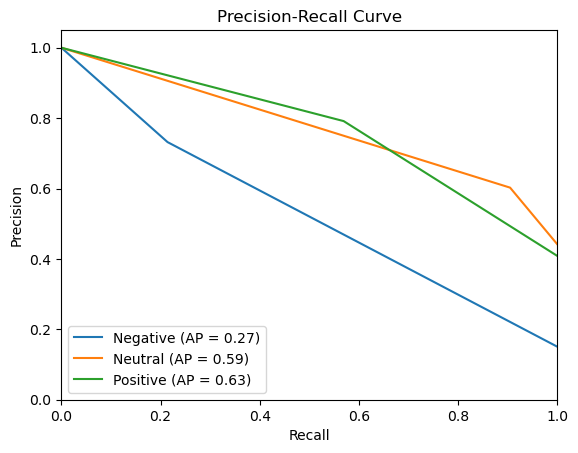

In [95]:
# Make predictions on the test set using the ensemble model with hard voting
test_pred = ensemble.predict(test_data_vectors)

# Get binary labels for each class
test_labels_negative = (test_data['label'] == 'negative')
test_labels_neutral = (test_data['label'] == 'neutral')
test_labels_positive = (test_data['label'] == 'positive')

# Get binary predictions for each class
test_pred_negative = (test_pred == 'negative')
test_pred_neutral = (test_pred == 'neutral')
test_pred_positive = (test_pred == 'positive')

# Calculate precision, recall, and average precision for each class
precision_negative, recall_negative, _ = precision_recall_curve(test_labels_negative, test_pred_negative)
precision_neutral, recall_neutral, _ = precision_recall_curve(test_labels_neutral, test_pred_neutral)
precision_positive, recall_positive, _ = precision_recall_curve(test_labels_positive, test_pred_positive)

average_precision_negative = average_precision_score(test_labels_negative, test_pred_negative)
average_precision_neutral = average_precision_score(test_labels_neutral, test_pred_neutral)
average_precision_positive = average_precision_score(test_labels_positive, test_pred_positive)

# Plot the precision-recall curves
plt.plot(recall_negative, precision_negative, label='Negative (AP = %0.2f)' % average_precision_negative)
plt.plot(recall_neutral, precision_neutral, label='Neutral (AP = %0.2f)' % average_precision_neutral)
plt.plot(recall_positive, precision_positive, label='Positive (AP = %0.2f)' % average_precision_positive)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

## Training Without Hyperparameter tuning And Ensemble

Test accuracy: 0.6069493146318138


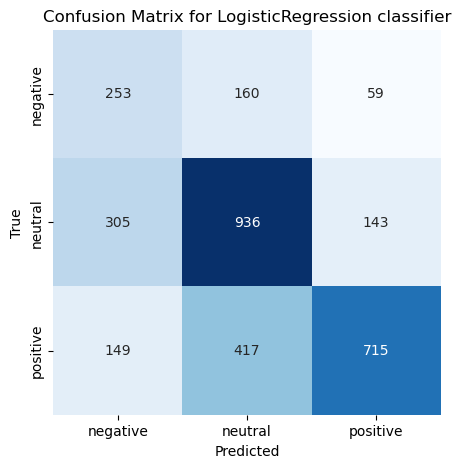

Classification Report:


,precision,recall,f1-score,support
negative,0.357850,0.536017,0.429177,472.000000
neutral,0.618638,0.676301,0.646186,1384.000000
positive,0.779716,0.558158,0.650591,1281.000000
accuracy,0.606949,0.606949,0.606949,0.606949
macro avg,0.585402,0.590158,0.575318,3137.000000
weighted avg,0.645176,0.606949,0.615333,3137.000000


In [159]:
#clf = MultinomialNB().fit(train_data_vectors, train_data['label'])
#clf = SVC()
#clf = RidgeClassifier()
#clf = LogisticRegression()
# clf = MLPClassifier()
clf = RandomForestClassifier()
clf.fit(train_data_vectors, train_data['label'])

# Make predictions on test data and calculate accuracy
test_pred = clf.predict(test_data_vectors)
test_accuracy = accuracy_score(test_data['label'], test_pred)

# # Print accuracies
print('Test accuracy:', test_accuracy)
cm = confusion_matrix(test_data['label'], test_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False, 
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LogisticRegression classifier')
plt.show()

# Print classification report and confusion matrix
print('Classification Report:')
report = classification_report(test_data['label'], test_pred, output_dict=True)
df = pd.DataFrame(report).transpose()
# print('Confusion Matrix:')
# print(confusion_matrix(test_data['label'], test_pred))
df.to_csv('MultinomialNB.csv')
df

In [6]:
X_train = train_vectors
X_test = test_vectors

y_train = train_df['label']
y_test = test_df['label']


In [13]:
#RidgeClassifier
rg_param = [{'alpha': [float("{:.2f}".format(i*0.1)) for i in range(11)],
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'max_iter': [i for i in range(100, 1100, 100)],
    'tol': [float(10**i) for i in range(-10, 0)],
    #'class_weight': np.append(['balanced', None], [dict(zip(classes,i)) for i in np.random.dirichlet(np.ones(len(classes)),size=10)]),
    'solver': ['auto', 'lsqr', 'sparse_cg', 'sag', 'saga'],
    'positive': [False],
    'random_state':[42]
            }]
rg_gs = RandomizedSearchCV(RidgeClassifier(), rg_param, n_jobs=-1, cv=5)
rg_gs.fit(X_train, y_train)

rg_best_params = rg_gs.best_params_
rg_clf = RidgeClassifier(alpha=rg_best_params['alpha'], fit_intercept=rg_best_params['fit_intercept'], normalize=rg_best_params['normalize'],
                        copy_X=rg_best_params['copy_X'], max_iter=rg_best_params['max_iter'], tol=rg_best_params['tol'], solver=rg_best_params['solver'],
                        positive=rg_best_params['positive'], random_state=rg_best_params['random_state'])
rg_pred = rg_gs.predict(X_test)
rg_acc = accuracy_score(y_test, rg_pred)
print('RG accuracy:', rg_acc)



ValueError: solver='lsqr' does not support fitting the intercept on sparse data. Please set the solver to 'auto' or 'sparse_cg', 'sag', 'lbfgs' or set `fit_intercept=False`

In [15]:
# Multinomial Naive Bayes
nb_param_grid = [{'alpha': [float("{:.2f}".format(i*0.1)) for i in range(1, 11)],
                'fit_prior': [True, False],}
                ]
nb_gs = GridSearchCV(MultinomialNB(), nb_param_grid, n_jobs=-1, cv=5)
nb_gs.fit(X_train, y_train)
nb_best_params = nb_gs.best_params_

nb_clf = MultinomialNB(alpha=nb_best_params['alpha'], fit_prior=nb_best_params['fit_prior'])

nb_pred = nb_gs.predict(X_test)
nb_acc = accuracy_score(y_test, nb_pred)
print('NB accuracy:', nb_acc)

NB accuracy: 0.570608861970035


In [17]:
#Linear Support Vector Machine
svm_param_grid = [{'penalty': ['l1', 'l2'], 
                   'loss': ['hinge', 'squared_hinge'],
                   'dual': [True, False],
                   'tol': [float(10**i) for i in range(-10, 0)],
                   'C': [float("{:.2f}".format(i*0.1)) for i in range(11)],
                   'multi_class': ['ovr', 'crammer_singer'],
                   'fit_intercept': [True, False],
                   'intercept_scaling': [float("{:.2f}".format(i*0.1)) for i in range(11)],
                   #'class_weight': np.append(['balanced', None], [dict(zip(classes,i)) for i in np.random.dirichlet(np.ones(len(classes)),size=10)]),
                   'verbose': [0],
                   'random_state': [42],
                   'max_iter': [i for i in range(100, 1100, 100)]}]
svm_gs = RandomizedSearchCV(LinearSVC(), svm_param_grid, n_jobs=-1, cv=5)
svm_gs.fit(X_train, y_train)
svm_best_params = svm_gs.best_params_

svm_clf = LinearSVC(penalty=svm_best_params['penalty'], loss=svm_best_params['loss'], tol=svm_best_params['tol'], C=svm_best_params['C'], fit_intercept=svm_best_params['fit_intercept'],
                            intercept_scaling=svm_best_params['intercept_scaling'], dual=svm_best_params['dual'], random_state=svm_best_params['random_state'],
                           multi_class=svm_best_params['multi_class'], verbose=svm_best_params['verbose'], max_iter=svm_best_params['max_iter'])

svm_pred = svm_gs.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print('SVM accuracy:', svm_acc)


SVM accuracy: 0.6002550207204336


In [ ]:
#Support Vector Machine

svm_param_grid = [{'C': [float("{:.2f}".format(i*0.1)) for i in range(11)],
                   'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                   #'degree': [i for i in range(1, 6)],
                   'gamma': ['scale', 'auto'],
                   #'shrinking': [True, False],
                   #'probability': [True, False],
                   #'tol': [float(10**i) for i in range(-10, 0)],
                   #'max_iter': [-1],
                   #'decision_function_shape': ['ovo', 'ovr']
                   }]

svm_gs = RandomizedSearchCV(SVC(), svm_param_grid, n_jobs=-1, cv=5)

In [ ]:
svm_gs.fit(X_train, y_train)
svm_best_params = svm_gs.best_params_

svm_clf = SVC(C=svm_best_params['C'], kernel=svm_best_params['kernel'], gamma=svm_best_params['gamma'],  
              #degree=svm_best_params['degree'],
              #shrinking=svm_best_params['shrinking'],
                            #probability=svm_best_params['probability'], tol=svm_best_params['tol'], max_iter=svm_best_params['max_iter'],
                           #decision_function_shape=svm_best_params['decision_function_shape']
             )

svm_pred = svm_gs.predict(X_test)
svm_acc = accuracy_score(y_test, svm_pred)
print('SVM accuracy:', svm_acc)

SVM accuracy: 0.641695887790883


In [12]:
# Logistic Regression
lr_param_grid = [{'penalty': ['l1', 'l2'],
    'dual': [False],
    'tol': [float(10**i) for i in range(-10, 0)],
    'C': [float("{:.2f}".format(i*0.1)) for i in range(11)],
    'fit_intercept': [True, False],
    'intercept_scaling': [float("{:.2f}".format(i*0.1)) for i in range(11)],
    #'class_weight': np.append(['balanced', None],[dict(zip(classes,i)) for i in np.random.dirichlet(np.ones(2),size=10)]),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'random_state': [42],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    'max_iter': [i for i in range(100, 1100, 100)],
    'verbose': [0],
    'warm_start': [True, False],
    'n_jobs': [-1],
    'l1_ratio': [float("{:.2f}".format(i*0.1)) for i in range(11)]}]

#{'C': [float("{:.2f}".format(i*0.1)) for i in range(11)]}
lr_gs = RandomizedSearchCV(LogisticRegression(), lr_param_grid, n_jobs=-1, cv=5)
lr_gs.fit(X_train, y_train)
lr_best_params = lr_gs.best_params_



lr_clf = LogisticRegression(penalty=lr_best_params['penalty'], dual=lr_best_params['dual'], C=lr_best_params['C'], fit_intercept=lr_best_params['fit_intercept'],
                            intercept_scaling=lr_best_params['intercept_scaling'], solver=lr_best_params['solver'], random_state=lr_best_params['random_state'],
                           multi_class=lr_best_params['multi_class'], max_iter=lr_best_params['max_iter'], verbose=lr_best_params['verbose'],
                            warm_start=lr_best_params['warm_start'], n_jobs=-1, l1_ratio=lr_best_params['l1_ratio'])


lr_pred = lr_gs.predict(X_test)
lr_acc = accuracy_score(y_test, lr_pred)
print('LR accuracy:', lr_acc)


In [74]:
mlp_clf = MLPClassifier(activation=mlp_best_params['activation'],
                        alpha=mlp_best_params['alpha'],
                       # batch_size=mlp_best_params['batch_size'],
                       # beta_1=mlp_best_params['beta_1'],
                       # beta_2=mlp_best_params['beta_2'],
                       # early_stopping=mlp_best_params['early_stopping'],
                       # epsilon=mlp_best_params['epsilon'],
                       hidden_layer_sizes=mlp_best_params['hidden_layer_sizes'],
                       # learning_rate=mlp_best_params['learning_rate'],
                       # learning_rate_init=mlp_best_params['learning_rate_init'],
                       # max_fun=mlp_best_params['max_fun'],
                       # momentum=mlp_best_params['momentum'],
                       # n_iter_no_change=mlp_best_params['n_iter_no_change'],
                       # nesterovs_momentum=mlp_best_params['nesterovs_momentum'],
                       # power_t=mlp_best_params['power_t'],
                       # random_state=mlp_best_params['random_state'],
                       # shuffle=mlp_best_params['shuffle'],
                       # solver=mlp_best_params['solver'],
                       # tol=mlp_best_params['tol'],
                       # validation_fraction=mlp_best_params['validation_fraction'],
                       # verbose=mlp_best_params['verbose'],
                       #warm_start=mlp_best_params['warm_start']
                       )

mlp_pred = mlp_gs.predict(X_test)
mlp_acc = accuracy_score(y_test, mlp_pred)
print('mlp accuracy:', mlp_acc)

mlp accuracy: 0.5173732865795346


In [107]:
# Random Forest
rf_param_grid = {'n_estimators': [100, 500, 1000], 'max_depth': [5, 10, 15], 'min_samples_split': [2, 5, 10]}
rf_gs = GridSearchCV(RandomForestClassifier(), rf_param_grid, n_jobs=-1, cv=5)
rf_gs.fit(X_train, y_train)
rf_best_params = rf_gs.best_params_

In [113]:
# Gradient Boosting
gb_param_grid = {'n_estimators': [100], 'max_depth': [5, 10, 15], 'learning_rate': [0.1, 1.0]}
gb_gs = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, n_jobs=-1, cv=5)
gb_gs.fit(X_train, y_train)
gb_best_params = gb_gs.best_params_

In [116]:


# Ensemble learning
nb_clf = MultinomialNB(alpha=nb_best_params['alpha'])
svm_clf = SVC(C=svm_best_params['C'], kernel=svm_best_params['kernel'], gamma=svm_best_params['gamma'])
lr_clf = LogisticRegression(C=lr_best_params['C'])
rf_clf = RandomForestClassifier(n_estimators=rf_best_params['n_estimators'], 
                                            max_depth=rf_best_params['max_depth'], 
                                            min_samples_split=rf_best_params['min_samples_split'])
gb_clf = GradientBoostingClassifier(n_estimators=gb_best_params['n_estimators'], 
                                    max_depth=gb_best_params['max_depth'], 
                                    learning_rate=gb_best_params['learning_rate'])
ensemble_clf = VotingClassifier(estimators=[('nb', nb_clf), ('svm', svm_clf), ('lr', lr_clf), ('rf', rf_clf), ('gb', gb_clf)], voting='hard')
ensemble_clf.fit(X_dev, y_dev)


# Evaluate models
nb_pred = nb_gs.predict(X_test)
svm_pred = svm_gs.predict(X_test)
lr_pred = lr_gs.predict(X_test)
rf_pred = rf_gs.predict(X_test)
gb_pred = gb_gs.predict(X_test)
ensemble_pred = ensemble_clf.predict(X_test)

nb_acc = accuracy_score(y_test, nb_pred)
svm_acc = accuracy_score(y_test, svm_pred)
lr_acc = accuracy_score(y_test, lr_pred)
rf_acc = accuracy_score(y_test, rf_pred)
gb_acc = accuracy_score(y_test, gb_pred)
ensemble_acc = accuracy_score(y_test, ensemble_pred)

print('NB accuracy:', nb_acc)
print('SVM accuracy:', svm_acc)
print('LR accuracy:', lr_acc)
print('RF accuracy:', rf_acc)
print('GB accuracy:', gb_acc)
print('Ensemble accuracy:', ensemble_acc)


NB accuracy: 0.5588141536499841
SVM accuracy: 0.6228881096589098
LR accuracy: 0.621931781957284
RF accuracy: 0.6012113484220593
GB accuracy: 0.6359579215811285
Ensemble accuracy: 0.5769843799808735


In [31]:
from textblob import TextBlob

# define a function to get the sentiment polarity of a tweet
def get_tweet_sentiment(tweet):
    analysis = TextBlob(tweet)
    return analysis.sentiment.polarity

# add a new column to the dataframe with the sentiment polarity score
train_df['sentiment_polarity'] = train_df['tweet_text'].apply(get_tweet_sentiment)

# get the average sentiment polarity score for each label
avg_polarity_by_label = train_df.groupby('label')['sentiment_polarity'].mean()

print(avg_polarity_by_label)


label
negative   -0.060829
neutral     0.053561
positive    0.293091
Name: sentiment_polarity, dtype: float64


The sentiment polarity values you have provided are the average sentiment polarity score for each label category in your dataset. Sentiment polarity is a measure of how positive or negative a text or a statement is. A score of 0 indicates a neutral sentiment, while positive scores indicate positive sentiments and negative scores indicate negative sentiments.

Based on your results, it seems that your dataset has a higher proportion of positive sentiments, as indicated by the higher sentiment polarity score of 0.293091 for the "positive" label. The "neutral" label has a smaller positive sentiment polarity score of 0.053561, suggesting that the tweets in this category are mostly neutral with some slight positive sentiment. The "negative" label has a negative sentiment polarity score of -0.060829, indicating that the tweets in this category tend to have a negative sentiment.

However, it's important to note that sentiment polarity scores are based on the sentiment analysis tool used and can be subjective. Additionally, the sentiment polarity scores may not necessarily reflect the true sentiment or emotions expressed in the tweets, as they can be affected by factors such as sarcasm, context, and cultural references.